In [1]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, TimeDistributed
from keras.callbacks import EarlyStopping
from extraction.extract import generateNNdata

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)


In [2]:
def genXy(data, lb, la, scaler):
    n_features = data.shape[1] - 2
    df = data.reindex()

    X = np.empty((0, lb, n_features))
    y = np.empty((0, la, 2))

    X_time = np.array([], dtype="datetime64")
    y_time = np.array([], dtype="datetime64")

    for i, row in df.iterrows():
        dfx = df.iloc[i : i + lb]
        x_vals = dfx.drop(columns=["timeslot", "date"]).values

        dfy = df.iloc[i + lb : i + lb + la]
        y_vals = dfy[["arrivalsArrivalDelay", "departuresDepartureDelay"]].values

        if dfx.shape[0] < lb or dfy.shape[0] < la:
            continue

        if dfx.date.nunique() > 1 or dfy.date.nunique() > 1:
            continue

        if dfx.date.unique()[0] != dfy.date.unique()[0]:
            continue

        x_vals = scaler.transform(x_vals)
        X = np.vstack((X, x_vals[None]))
        y = np.vstack((y, y_vals[None]))

        X_time = np.append(X_time, dfx.timeslot.iloc[0])
        y_time = np.append(y_time, dfy.timeslot.iloc[0])

    return X, y, X_time, y_time


In [3]:
timeinterval = 30
airport = "EGLL"
lookback, lookahead = 6, 6


In [4]:
dataset = (
    generateNNdata(
        airport,
        timeslotLength=timeinterval,
        catagoricalFlightDuration=False,
        forceRegenerateData=True,
    )
    .drop(columns=["departuresArrivalDelay", "arrivalsDepartureDelay"])
    .assign(hour=lambda d: d.timeslot.dt.hour)
    .assign(capacityFilled=lambda d: d.capacityFilled * 100)
)


Generating NN data for EGLL with a timeslot length of 30 minutes


In [5]:
# randomly split train, validation, test with 60%, 20%, 20%

np.random.seed(42)
dates = dataset.date.unique()
np.random.shuffle(dates)

idx_split = int(len(dates) * 0.75)

train_dates = dates[:idx_split]
test_dates = dates[idx_split:]

train_data = dataset.query("date in @train_dates").sort_values('timeslot')
test_data = dataset.query("date in @test_dates").sort_values('timeslot')


In [6]:
scaler = StandardScaler()
scaler.fit(dataset.drop(columns=["timeslot", "date"]).values)

StandardScaler()

In [7]:
X_train, y_train, X_train_time, y_train_time = genXy(train_data, lookback, lookahead, scaler)
X_test, y_test, X_test_time, y_test_time = genXy(test_data, lookback, lookahead, scaler)

y_train_arr, y_train_dep = y_train[:, :, 0], y_train[:, :, 1]
y_test_arr, y_test_dep = y_test[:, :, 0], y_test[:, :, 1]


In [23]:
n_timesteps = X_train.shape[1]
n_features = X_train.shape[2]


In [ ]:

# model = Sequential()
# model.add(LSTM(400, input_shape=(n_timesteps, n_features), return_sequences=True))
# model.add(Dropout(0.25))
# model.add(LSTM(200, input_shape=(n_timesteps, n_features), return_sequences=True))
# model.add(Dropout(0.25))
# model.add(TimeDistributed(Dense(100)))
# model.add(Dropout(0.25))
# model.add(TimeDistributed(Dense(2)))

# model.compile(loss="mse", optimizer="adam")

# model.summary()


In [24]:
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.losses import MeanSquaredError


inputs = layers.Input((lookback, n_features))
lstm1 = layers.LSTM(200, return_sequences=True)
lstm2 = layers.LSTM(200, return_sequences=False)
dense1 = layers.Dense(200)
dropout1 = layers.Dropout(0.25)
dense2 = layers.Dense(100)
output = layers.Dense(lookahead * 2)
reshape = layers.Reshape((lookahead, 2))

out = lstm1(inputs)
out = lstm2(out)
out = dense1(out)
out = dropout1(out)
out = dense2(out)
outputs = output(out)
outputs = reshape(outputs)

model = models.Model(inputs, outputs)

optimizer = optimizers.Adam()
model.compile(
    optimizer=optimizer,
    loss=MeanSquaredError(reduction="auto", name="mean_squared_error"),
    weighted_metrics=["acc"],
)

model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 6, 12)]           0         
                                                                 
 lstm_4 (LSTM)               (None, 6, 200)            170400    
                                                                 
 lstm_5 (LSTM)               (None, 200)               320800    
                                                                 
 dense_4 (Dense)             (None, 200)               40200     
                                                                 
 dropout_4 (Dropout)         (None, 200)               0         
                                                                 
 dense_5 (Dense)             (None, 100)               20100     
                                                                 
 dense_6 (Dense)             (None, 12)                1212  

Epoch 1/100
238/238 [==============================] - 6s 13ms/step - loss: 61.5183 - acc: 0.9354 - val_loss: 40.5332 - val_acc: 0.9410
Epoch 2/100
238/238 [==============================] - 2s 9ms/step - loss: 45.2083 - acc: 0.9468 - val_loss: 40.6624 - val_acc: 0.9352
Epoch 3/100
238/238 [==============================] - 2s 9ms/step - loss: 40.4654 - acc: 0.9462 - val_loss: 37.4819 - val_acc: 0.9391
Epoch 4/100
238/238 [==============================] - 2s 9ms/step - loss: 37.8756 - acc: 0.9468 - val_loss: 35.5218 - val_acc: 0.9459
Epoch 5/100
238/238 [==============================] - 2s 9ms/step - loss: 35.8931 - acc: 0.9473 - val_loss: 34.3565 - val_acc: 0.9436
Epoch 6/100
238/238 [==============================] - 2s 9ms/step - loss: 33.9995 - acc: 0.9470 - val_loss: 31.8478 - val_acc: 0.9481
Epoch 7/100
238/238 [==============================] - 2s 9ms/step - loss: 32.8807 - acc: 0.9480 - val_loss: 31.7972 - val_acc: 0.9503
Epoch 8/100
238/238 [==============================] -

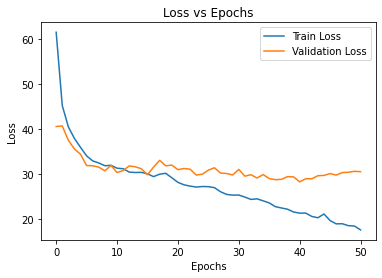

In [25]:

es = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=10)

# Fit data
history = model.fit(
    X_train,
    y_train,
    epochs=100,
    validation_data=(X_test, y_test),
    # verbose=0,
    shuffle=False,
    callbacks=[es],
)

# Plot loss
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [26]:
y_test_hat = model.predict(X_test)


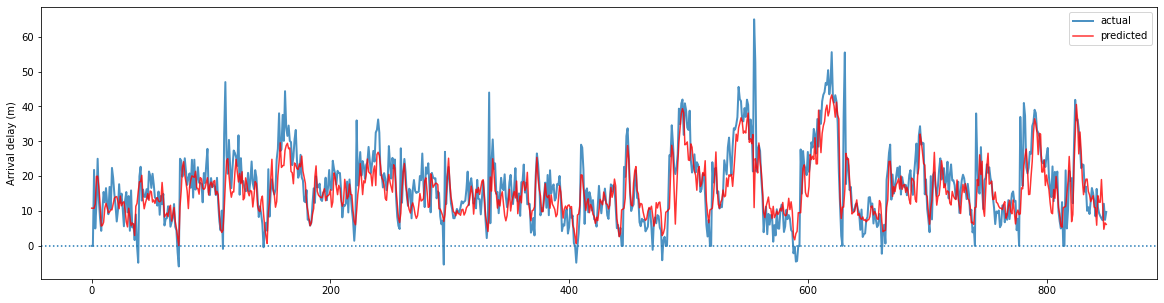

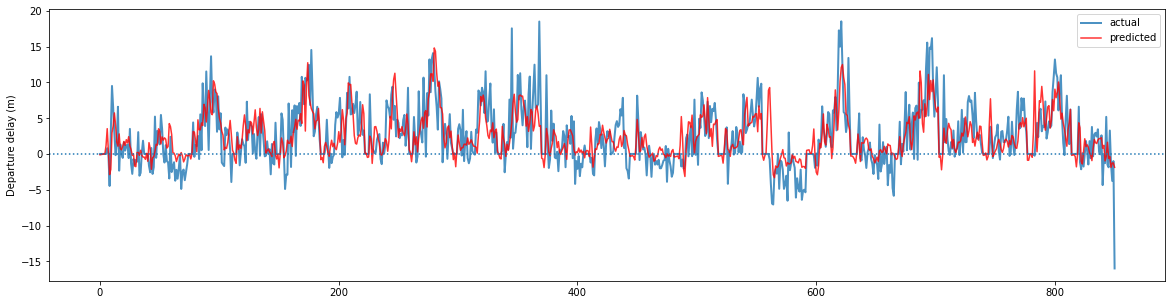

In [27]:
plt.figure(figsize=(20, 5))
plt.plot(y_test_arr[:, 0], lw=2, alpha=0.8, label="actual")
plt.plot(y_test_hat[:, 0, 0], color="r", alpha=0.8, label="predicted")
plt.axhline(0, ls=":")
plt.ylabel("Arrival delay (m)")
plt.legend()
plt.show()

plt.figure(figsize=(20, 5))
plt.plot(y_test_dep[:, 0], lw=2, alpha=0.8, label="actual")
plt.plot(y_test_hat[:, 0, 1], color="r", alpha=0.8, label="predicted")
plt.axhline(0, ls=":")
plt.ylabel("Departure delay (m)")
plt.legend()
plt.show()


In [28]:
results = pd.concat(
    [
        pd.DataFrame().assign(time=y_test_time),
        pd.DataFrame(
            y_test[:, :, 0].round().astype(int),
            columns=[f"arr_{n}m" for n in range(30, 181, 30)],
        ),
        pd.DataFrame(
            y_test[:, :, 1].round().astype(int),
            columns=[f"dep_{n}m" for n in range(30, 181, 30)],
        ),
        pd.DataFrame(
            y_test_hat[:, :, 0].round().astype(int),
            columns=[f"arr_est_{n}m" for n in range(30, 181, 30)],
        ),
        pd.DataFrame(
            y_test_hat[:, :, 1].round().astype(int),
            columns=[f"dep_est_{n}m" for n in range(30, 181, 30)],
        ),
    ],
    axis=1,
)

# results


In [29]:
res = dict()
for i in range(1, 7):
    res[i] = {
        "arr_mae": mean_absolute_error(results[f"arr_{i*30}m"], results[f"arr_est_{i*30}m"]),
        "arr_rmse": mean_squared_error(
            results[f"arr_{i*30}m"], results[f"arr_est_{i*30}m"], squared=False
        ),
        "arr_r2": r2_score(results[f"arr_{i*30}m"], results[f"arr_est_{i*30}m"]),
        "dep_mae": mean_absolute_error(results[f"dep_{i*30}m"], results[f"dep_est_{i*30}m"]),
        "dep_rmse": mean_squared_error(
            results[f"dep_{i*30}m"], results[f"dep_est_{i*30}m"], squared=False
        ),
        "dep_r2": r2_score(results[f"dep_{i*30}m"], results[f"dep_est_{i*30}m"]),
    }

pd.DataFrame.from_dict(res, orient="index")

,arr_mae,arr_rmse,arr_r2,dep_mae,dep_rmse,dep_r2
1,4.743831,6.686096,0.574328,2.339600,3.192051,0.395061
2,4.663925,6.322604,0.609073,2.480611,3.339927,0.355497
3,4.772033,6.412843,0.598589,2.668625,3.716606,0.270495
4,5.078731,6.834281,0.568149,2.942421,3.989999,0.198305
5,5.278496,7.137890,0.550586,3.079906,4.272036,0.118653
6,5.457109,7.514967,0.516917,3.215041,4.353639,0.091428


In [30]:

results.to_csv("data/airport_delay_lstm_results.csv", index=False)
